# Content

[Pre-processing](#section1)
- [Preliminary Filters (POC, Heating, Sky, PricingVersionDescription)](#prefilt)
- [Dedup](#dedup)
- [Rename & Drop Columns](#rename)
- [Data Formatting](#form)
- [Basic Stats](#stats)
- [Categorical Features](#catfeat)
- [Numerical Features](#numfeat)
- [Date Features(Formatting, Feature Engineering - offermonthyear, startmonthyear,contractmonthyear, offereventmonth, startmonth, contractmonth, contract_age, item_age)](#datefeat)
- [Target Variable (cancelflag)](#target)

[Cohort Analysis & Filter](#section2)
- [Cohort Filter (Jun & Jul '21 start dates)](#cofilt)
- [Cancellation Rate by Months of Tenure: 12](#canx)

[Merge with Geovariable](#section3)
- [Merge](#merge)
- [Impute](#imp)
- [Drop Postcode Columns](#droppc)

[Final Processing](#section4)
- [Split columns by type](#split)
- [Count unique values](#countval)
- [Single Value & Null Columns](#singlenull)
- [Clean up](#clean)
- [Impute Categorical Features](#impcat)
- [Impute Numerical Features](#impnum)
- [Impute Claims Features](impclaim)
- [Binning, Capping & Outlier Treatment (PurchasePrice, item_price_bin, HPI_AveragePrice, ClaimPast5YearCount, claimpastfiveyearcount_bin)](#bin)
- [Redundant & Leaky Features](#leak)
- [Outlier Treatment](#out)

[Modelling](#section5)
- [Feature Importance](#featimp)
- [Multicollinearity](#multicol)
- [Model 1: GBM](#gbm)
- [Model 2: GLM](#glm)
- [Model 3: Random Forest](#rf)

# Pre-Processing 
<a id="section1"></a>

In [1]:

# Reloading
%reload_ext autoreload
%autoreload 2

import pandas as pd
print('pandas version:{}'.format(pd.__version__))
import numpy as np
print('numpy version:{}'.format(np.__version__))
import math
from datetime import datetime
from dgpylib import dg_athena
from dgpylib import dg_s3
import os
import re
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import sys
sys.path.insert(0, '../Modelling')
import helper_function2 as hf

import sys
sys.path.insert(0, '../EDA')
import data_integrity_fixer as dint
import basicstatsandplotter as bsp
import data_imputer as di
import data_integrity_fixer as dif
import parameters

##for modelling
import h2o
print('h2o version:{}'.format(h2o.__version__))
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OTargetEncoderEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.tree import H2OTree
from h2o.tree import H2ONode
from h2o.tree import H2OSplitNode
from h2o.tree import H2OLeafNode
from h2o.estimators.kmeans import H2OKMeansEstimator

#import xgboost as xgb
import sklearn
import category_encoders as ce
print('sklearn version:{}'.format(sklearn.__version__))
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.preprocessing import PowerTransformer
import time
import parameters
from statsmodels.stats.outliers_influence import variance_inflation_factor

%run 'functions.ipynb'

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

pandas version:1.3.4
numpy version:1.20.3
h2o version:3.36.0.4
sklearn version:1.1.2


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
conn_s3 = dg_s3.Connect('dgdatadump/DS&CA/Pricing/02 Projects/2022/Tel_Reg_2.0/Cancellation Model')
df_raw = conn_s3.read('TelReg_Cancellation_Planmaster.csv')
print(df_raw.shape)
print(df_raw['movementdate'].min(), df_raw['movementdate'].max())
print(df_raw['planaccdate'].min(), df_raw['planaccdate'].max())

(751582, 92)
1210102 1220818
1210101 1220817


## Preliminary Filters
<a id='prefilt'></a>

In [4]:
# keep only POC == 12 months
df_raw =  df_raw[df_raw['PeriodOfCover']==12]

# filter out Sky, Heating
df_raw = df_raw[(df_raw['manufacturerbrandname']!='SKY')&(df_raw['itemgoodscategoryname']!='HEATING')]
df_raw.shape

df_raw = df_raw.loc[df_raw.PricingVersionDescription != 'TEST']

## Dedup
<a id='dedup'></a>

In [5]:
# check duplicate offers
df_raw[df_raw.duplicated(subset='offerreferencenumber')].shape

# dedup offers
df_dedup = df_raw.drop_duplicates(subset='offerreferencenumber', keep='first')
df_dedup.shape, df_raw.shape

((721573, 92), (726675, 92))

## Rename & Drop Columns
<a id='rename'></a>

In [6]:
rename_list = parameters.rename_list
drop_list = parameters.drop_list

In [7]:
df = df_dedup.copy()
df.rename(columns=rename_list, inplace=True)
df = hf.drop_columns(df, drop_list)

df.shape, df_raw.shape

((721573, 49), (726675, 92))

## Data Formatting
<a id='form'></a>

In [8]:
# # Convert to Int
# for col in ['ClaimPast1YearCount', 'ClaimPast3YearCount', 'ClaimPast5YearCount', 'PlanLiveCount', 'PlansAcceptedPast1YearCount', 'PlansAcceptedPast5YearCount', 'PlansActivePast1yrCount', 'PlansActivePast5yrCount', 'PlansCancelledPast1YearCount', 'PlansCancelledPast5YearCount']:
#     df[col]= df[col].astype('Int64')
    
# Convert to Datetime
df['CurrentDate'] = pd.to_datetime(df['CurrentDate']) 
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

# Convert to String
for i in ['ClientGroupCode', 'ClientCode']:
    df[i] = np.where(df[i].isna(), df[i], df[i].astype('string'))
    print(i, ':', df[i].isna().sum(), df[i].dtypes)
    # print(dif.get_othernulls_count(df[i]))
# df.astype({"PmhId":str,"PerhId":str ,"ClientGroupCode": str,  "ClientCode": str})

# Create new features
df['HasPrevRTPPrice'] = np.where(df['PrevRTPPriceType'].isna(), 'N', 'Y')
df['AppAge'] = (df['CurrentDate'] - df['PurchaseDate']) / np.timedelta64(1, 'D')
df['relFee'] = df['Fee']/ df['PurchasePrice']
df['relFeeInc'] = df['price_diff']/ df['PurchasePrice']
df['PaymentType']= 'DD'

# Impute Counts in Pricing Table
to_impute = ['PlanLiveCount', 'PlansActivePast1yrCount',
       'PlansActivePast5yrCount', 'PlansAcceptedPast1YearCount',
       'PlansAcceptedPast5YearCount', 'PlansCancelledPast1YearCount',
       'PlansCancelledPast5YearCount', 'ClaimPast1YearCount',
       'ClaimPast3YearCount', 'ClaimPast5YearCount',
       'ClaimAmount1YearTotal', 'ClaimAmount3YearTotal', 'ClaimAmount5YearTotal']

df[to_impute] = df[to_impute].fillna(0)


ClientGroupCode : 198153 object
ClientCode : 198153 object


## Basic Statistics
<a id='stats'></a>

In [9]:
#dtypes
x= df.dtypes.to_frame().reset_index()
x.columns = ['ColName', 'dtype']
x= x.sort_values(by= 'ColName')

#missing
y= df.isna().sum().to_frame().reset_index()
y.columns = ['ColName', 'Na_rows']
y= y.sort_values(by= 'ColName')

#describe
d= df.describe(percentiles= [.1, .9, .95, .975]).T.reset_index()
d.columns = ['ColName', 'count', 'mean', 'std', 'min', '10%', '50%', '90%', '95%', '97.5%', 'max']
d= d.sort_values(by= 'ColName')

#join
z= x.merge(y, on= 'ColName', how= 'left').merge(d, on='ColName', how= 'left')
z['N'] = df.shape[0]
z['Na_miss_rate'] = (z['Na_rows'] / z['N']) * 100

z['dtype'] = z['dtype'].astype('str')

fltr= z['dtype'].isin(['float64'])
z.style.format('{:,.2f}', subset=['mean', 'std', 'min', '10%', '50%', '90%', '95%', '97.5%', 'max', 'Na_miss_rate']).format('{:,.0f}', subset=['N', 'Na_rows', 'count'])

,ColName,dtype,Na_rows,count,mean,std,min,10%,50%,90%,95%,97.5%,max,N,Na_miss_rate
0,AppAge,float64,"198,153","523,420",107.61,189.65,0.00,0.00,14.00,365.00,549.05,731.00,"1,217.00","721,573",27.46
1,ApplianceCode,object,"198,153",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"721,573",27.46
2,ClaimAmount1YearTotal,float64,0,"721,573",38.67,168.53,0.00,0.00,0.00,85.03,223.57,428.08,"9,198.77","721,573",0.00
3,ClaimAmount3YearTotal,float64,0,"721,573",93.11,351.13,-254.84,0.00,0.00,253.42,561.78,953.48,"17,209.60","721,573",0.00
4,ClaimAmount5YearTotal,float64,0,"721,573",132.97,474.49,"-7,127.94",0.00,0.00,373.83,805.03,"1,318.17","22,468.61","721,573",0.00
5,ClaimPast1YearCount,float64,0,"721,573",0.30,1.07,0.00,0.00,0.00,1.00,2.00,3.00,54.00,"721,573",0.00
6,ClaimPast3YearCount,float64,0,"721,573",0.75,2.43,0.00,0.00,0.00,2.00,5.00,7.00,124.00,"721,573",0.00
7,ClaimPast5YearCount,float64,0,"721,573",1.11,3.50,0.00,0.00,0.00,4.00,7.00,11.00,181.00,"721,573",0.00
8,ClientAccountDesc,object,"198,153",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"721,573",27.46
9,ClientCode,object,"198,153",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"721,573",27.46


## Categorical Features
<a id='catfeat'></a>

In [10]:
cat_features = [f for f in df.select_dtypes(include=['object']).columns.sort_values() if f not in ['CurrentDate', 'PurchaseDate', 'ons_postcode_sector', 'PerPostalAddrPostCode', 'RouteToMarketName', 'PrevRTPPriceType', 'SchemeTypeName']]
cat_features

['ApplianceCode',
 'ClientAccountDesc',
 'ClientCode',
 'ClientGroupCode',
 'ClientGroupDesc',
 'GoodsColour',
 'HasPrevRTPPrice',
 'ManufacturerBrandCode',
 'ModelId',
 'PaymentType',
 'Postcode_Sector',
 'PricingVersionDescription',
 'cocode',
 'contractstatuscode',
 'itemeventuserid',
 'offerpostcode',
 'offerreferencenumber',
 'personaddresspostcode',
 'price_band',
 'schcode']

In [11]:
for i in cat_features:
    print(i, ':', df[i].nunique())

ApplianceCode : 111
ClientAccountDesc : 38
ClientCode : 84
ClientGroupCode : 54
ClientGroupDesc : 20
GoodsColour : 2
HasPrevRTPPrice : 2
ManufacturerBrandCode : 114
ModelId : 8
PaymentType : 1
Postcode_Sector : 10583
PricingVersionDescription : 17
cocode : 1
contractstatuscode : 4
itemeventuserid : 2267
offerpostcode : 327306
offerreferencenumber : 721573
personaddresspostcode : 323200
price_band : 7
schcode : 167


In [12]:
id_cols = ['offerreferencenumber', 'itemeventuserid', 'ModelId']
postcode_cols = ['personaddresspostcode', 'offerpostcode', 'Postcode_Sector']

to_group = list(set(cat_features) - set(id_cols) - set(postcode_cols))

group_low_freq(df=df, lst= to_group, pct=2.5) # regroup very low frequency classes

for i in to_group:  # check unique values after regrouping
    print(i, ':', df[i].nunique())

ApplianceCode : 12
ClientAccountDesc : 12
price_band : 7
PricingVersionDescription : 5
cocode : 1
PaymentType : 1
ClientCode : 9
GoodsColour : 2
ClientGroupCode : 7
ManufacturerBrandCode : 12
contractstatuscode : 3
schcode : 14
HasPrevRTPPrice : 2
ClientGroupDesc : 9


## Numerical Features
<a id='numfeat'></a>

In [13]:
num_features = [f for f in df.select_dtypes(include=['int32', 'int64', 'float64']).columns.sort_values() if f not in ['planno']]
num_features

['AppAge',
 'ClaimAmount1YearTotal',
 'ClaimAmount3YearTotal',
 'ClaimAmount5YearTotal',
 'ClaimPast1YearCount',
 'ClaimPast3YearCount',
 'ClaimPast5YearCount',
 'Fee',
 'ManufacturerGuaranteeLabourMonths',
 'ManufacturerGuaranteePartsMonths',
 'PeriodOfCover',
 'PlanLiveCount',
 'PlansAcceptedPast1YearCount',
 'PlansAcceptedPast5YearCount',
 'PlansActivePast1yrCount',
 'PlansActivePast5yrCount',
 'PlansCancelledPast1YearCount',
 'PlansCancelledPast5YearCount',
 'PredictedConversionRate',
 'PurchasePrice',
 'RetentionFlag',
 'TotalPrice',
 'movementdate',
 'offertotalprice',
 'planaccdate',
 'price_diff',
 'relFee',
 'relFeeInc',
 'sale']

In [14]:
# for col in num_features:
#     df[col]= df[col].clip(upper= np.quantile(df[col], q= 0.95))
#     df[col]= df[col].clip(lower= np.quantile(df[col], q= 0.05))

## Date Features
<a id='datefeat'></a>

### Formatting

In [15]:
date_cols = df.columns[df.columns.str.lower().str.contains('date')]
df = planmaster_date_to_datetime(df, columns=['planaccdate', 'movementdate']) # convert planmaster to datetime string
date_fix(df, date_cols) # convert to datetime

print(df['CurrentDate'].min(), df['CurrentDate'].max())
print(df['movementdate'].min(), df['movementdate'].max())
print(df['planaccdate'].min(), df['planaccdate'].max())

2021-01-01 00:00:00 2022-08-01 00:00:00
2021-01-02 00:00:00 2022-08-18 00:00:00
2021-01-01 00:00:00 2022-08-17 00:00:00


### Feature Engineering

In [16]:
# month-year column
# df_dedup['offermonthyear'] = df_dedup['CurrentDate'].dt.to_period('M')
df['startmonthyear'] = df['planaccdate'].dt.to_period('M')
df['contractmonthyear'] = df['movementdate'].dt.to_period('M')

# month name column
# df_dedup['offereventmonth'] = df_dedup['CurrentDate'].dt.month_name()
df['startmonth'] = df['planaccdate'].dt.month_name()
df['contractmonth'] = df['movementdate'].dt.month_name()

In [17]:
# calculate contract tenure
final_date = df['movementdate'].max()
df['contract_age']=df['contract_age']=np.where(df['contractstatuscode']=='C', (df['movementdate']-df['planaccdate'])/np.timedelta64(1, 'M'), (final_date-df['planaccdate'])/np.timedelta64(1, 'M'))
df[df['contract_age']<0].shape
# df_dedup.drop('contract_age', axis=1, inplace=True)

(0, 61)

In [18]:
# # calculate item age

# df['item_age'] = np.where(pd.to_datetime(df['CurrentDate'])>=pd.to_datetime(df['PurchaseDate']),(pd.to_datetime(df['CurrentDate']) - pd.to_datetime(df['PurchaseDate'])) / np.timedelta64(1, 'M'), np.nan)
# df['item_age'] = df['item_age'].fillna(df['item_age'].mean())

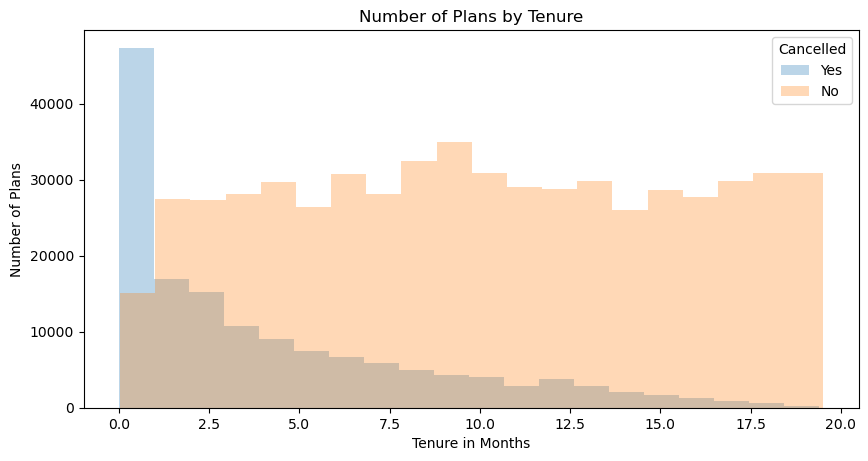

In [19]:
x1 = df[df['contractstatuscode']=='C']['contract_age']
x2 = df[df['contractstatuscode']!='C']['contract_age']
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=20)
plt.hist(x1.values, **kwargs, label = "Yes")
plt.hist(x2.values, **kwargs, label = "No")
plt.xlabel("Tenure in Months")
plt.ylabel("Number of Plans")
plt.title("Number of Plans by Tenure")
plt.legend(title='Cancelled')
plt.show()

## Target Variable: Cancellation Flag
<a id='target'></a>

In [20]:
# create target variable for the model
df['cancelflag']=np.where(df['contractstatuscode']=='C', 1, 0)
df['cancelflag'].sum(), df.shape

(149116, (721573, 62))

In [23]:
df_raw1 = df.copy()

# Cohort Analysis & Filter
<a id='section2'></a>

## Cohort Filter
<a id='cofilt'></a>

In [24]:
# Cohort Filter - select only jun & jul 21 start dates

filt_df = df_raw1[(df_raw1['planaccdate']>='2021-06-01')&(df_raw1['planaccdate']<'2021-08-01')]
filt_df.shape

(78471, 62)

## Cancellation Rate by Months of Tenure: 12 months
With 12-month observation period
<a id='canx'></a>

In [25]:
final_planaccdate = pd.Timestamp('2021-07-31 00:00:00')
final_movementdate = final_planaccdate + relativedelta(months=12)
final_movementdate

Timestamp('2022-07-31 00:00:00')

In [26]:
# re-calculate contract_age
filt_df12 = filt_df.copy()
filt_df12['contract_age']=np.where(filt_df12['contractstatuscode']=='C',(filt_df12['movementdate']-filt_df12['planaccdate'])/np.timedelta64(1, 'M'), (final_movementdate-filt_df12['planaccdate'])/np.timedelta64(1, 'M'))

filt_df12[filt_df12['contractstatuscode']=='C']['contract_age'].describe()

count    19266.000000
mean         4.683772
std          4.168502
min          0.000000
25%          0.722807
50%          3.581182
75%          8.016592
max         14.357584
Name: contract_age, dtype: float64

In [27]:
filt_df12.shape

(78471, 62)

In [28]:
# re-label plans that cancelled after 12 months
filt_df12['contractstatuscode'] = np.where((filt_df12['contractstatuscode']=='C')&(filt_df12['contract_age']>=12), 'N', filt_df12['contractstatuscode'])
filt_df12[filt_df12['contractstatuscode']=='C']['contract_age'].max()

11.992032690609664

In [29]:
# re-label cancelflag
filt_df12['cancelflag']=np.where(filt_df12['contractstatuscode']=='C', 1, 0)

array([[<AxesSubplot:title={'center':'contract_age'}>]], dtype=object)

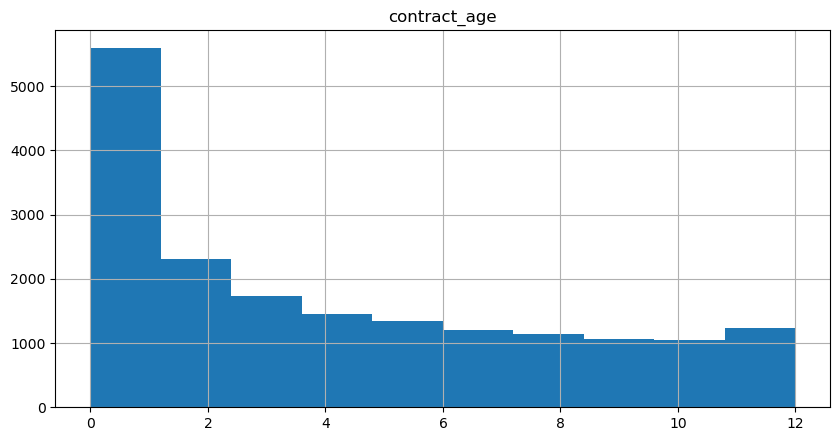

In [30]:
# plot distribution of contract tenure for cancelled contracts
df_canx_tenure = pd.DataFrame(filt_df12[filt_df12['contractstatuscode']=='C']['contract_age'])
df_canx_tenure.hist()

In [31]:
filt_df12['startmonthyear'] = filt_df12['startmonthyear'].astype(str)

In [32]:
df_month = pd.DataFrame(filt_df12.groupby(['startmonthyear']).agg({'cancelflag': lambda x: x.sum(),'offerreferencenumber': lambda x: x.count()})).reset_index()

df_month.columns = ['startmonthyear','cancel_count', 'offers']
# df_month['cum_cancels'] = df_month['cancel_count'].cumsum()
# df_month['cum_offers'] = df_month['offers'].cumsum()
# df_month['cum_cancel_rate'] = df_month['cum_cancels']/df_month['cum_offers']
df_month['cancel_rate'] = df_month['cancel_count']/(df_month['offers'])

  startmonthyear  cancel_count  offers  cancel_rate
0        2021-06          8947   38997     0.229428
1        2021-07          9167   39474     0.232229


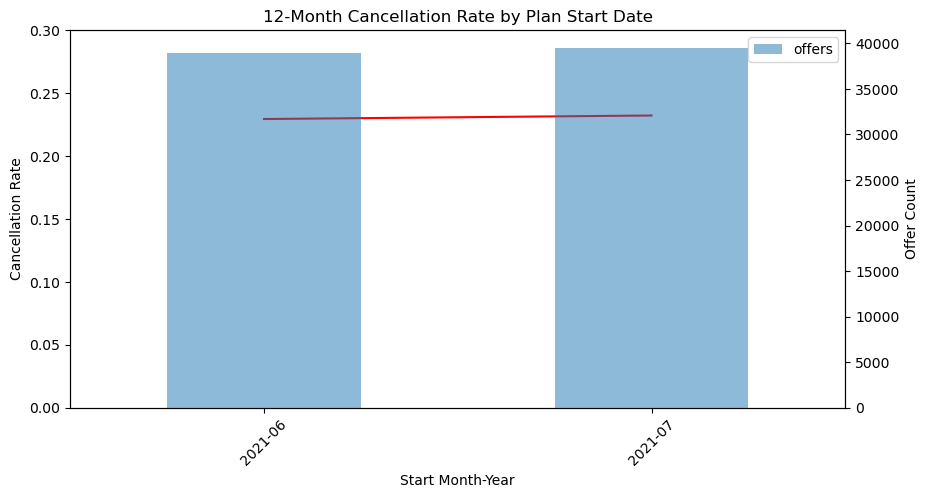

In [33]:
# Plot cancellation rate

y1 = df_month['cancel_rate']
y2 = df_month['offers']

x = df_month['startmonthyear']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, y1, color = 'red', label = 'Cancellation Rate')
y2.plot.bar(alpha=0.5)


# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel("Start Month-Year")
ax1.set_ylabel("Cancellation Rate")
ax2.set_ylabel("Offer Count")
ax1.set_xticklabels(x, rotation=45)

ax1.set_xticklabels(x)
ax1.set_ylim([0, .3])

plt.legend()
plt.title('12-Month Cancellation Rate by Plan Start Date')

print(df_month)

plt.show()

# Merge with Geovariable
<a id='section3'></a>

In [34]:
telreg = filt_df12.copy()

In [35]:
conn1 = dg_s3.Connect('dgdatadump/DS&CA/Reference Files/ONS/Processed')
geo_df = conn1.read('Earnix_Geo_Look_Up_by_PC.csv')

In [36]:
all_features = geo_df.columns

ons_feats = all_features[all_features.str.contains('ONS_')]
ons_feats = ons_feats.to_list()

hpi_feats =['HPI_AveragePrice', 'HPI_SalesVolume']

geo_feats = hpi_feats + ons_feats
geo_feats

['HPI_AveragePrice',
 'HPI_SalesVolume',
 'ONS_Unnamed: 0',
 'ONS_postcode_sector',
 'ONS_avg_age',
 'ONS_avg_distance_travelled_to_work(km)',
 'ONS_%people_working_FT',
 'ONS_%people_working_49+',
 'ONS_%people_working_sum',
 'ONS_avg_household_size',
 'ONS_n_households',
 'ONS_avg_dependent_children_per_family',
 'ONS_n_families',
 'ONS_n_families/n_households',
 'ONS_avg_bedrooms',
 'ONS_avg_rooms',
 'ONS_bedrooms per rooms',
 'ONS_population',
 'ONS_population_density',
 'ONS_occupation_rate',
 'ONS_n_families_per_population']

In [37]:
geo_feats.remove('ONS_postcode_sector')
geo_feats.remove('ONS_Unnamed: 0')

## Merge
<a id="merge"></a>

In [38]:
geo_df.pcds.nunique(), telreg.offerpostcode.nunique()

(2652196, 44846)

In [39]:
geo_df.columns

Index(['LAD_name', 'LAD_code', 'country', 'region', 'pcds', 'AreaCode',
       'RegionName', 'HPI_AveragePrice', 'HPI_SalesVolume', 'postcode_sector',
       'ONS_Unnamed: 0', 'ONS_postcode_sector', 'ONS_avg_age',
       'ONS_avg_distance_travelled_to_work(km)', 'ONS_%people_working_FT',
       'ONS_%people_working_49+', 'ONS_%people_working_sum',
       'ONS_avg_household_size', 'ONS_n_households',
       'ONS_avg_dependent_children_per_family', 'ONS_n_families',
       'ONS_n_families/n_households', 'ONS_avg_bedrooms', 'ONS_avg_rooms',
       'ONS_bedrooms per rooms', 'ONS_population', 'ONS_population_density',
       'ONS_occupation_rate', 'ONS_n_families_per_population'],
      dtype='object')

In [40]:
geo_df['postcode_sector'].head()

0    BT251
1    BT251
2    BT251
3    BT251
4    BT251
Name: postcode_sector, dtype: object

In [41]:
# merge 
telreg_merged = telreg.merge(geo_df, how='left', left_on='offerpostcode', right_on='pcds')

<AxesSubplot:>

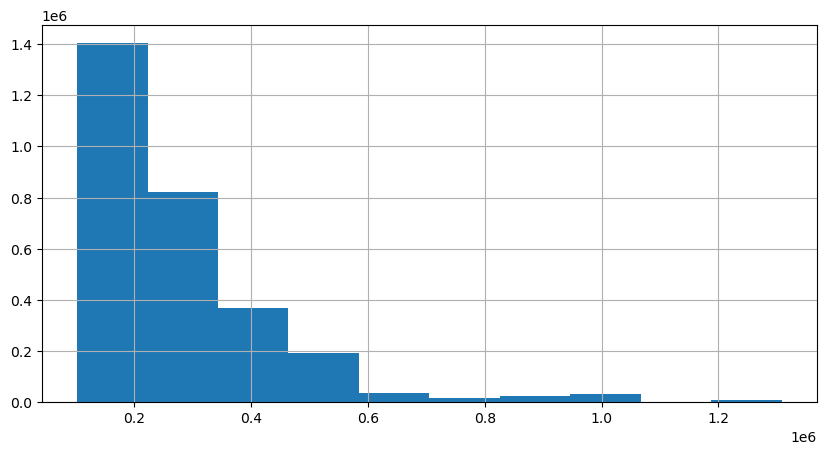

In [42]:
geo_df['HPI_AveragePrice'].hist()

In [43]:
# dedup
telreg_dedup = telreg_merged.drop_duplicates(subset=['offerreferencenumber'], keep='first')

# check
telreg_dedup.duplicated(subset=['offerreferencenumber']).any()

False

In [44]:
telreg_dedup.drop('ONS_Unnamed: 0', inplace=True, axis=1)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [45]:
# check missing values in geo_feats
for col in geo_feats:
    print(f'{col}: {telreg_dedup[col].isna().sum()}')

HPI_AveragePrice: 549
HPI_SalesVolume: 549
ONS_avg_age: 549
ONS_avg_distance_travelled_to_work(km): 549
ONS_%people_working_FT: 549
ONS_%people_working_49+: 549
ONS_%people_working_sum: 549
ONS_avg_household_size: 549
ONS_n_households: 549
ONS_avg_dependent_children_per_family: 549
ONS_n_families: 549
ONS_n_families/n_households: 549
ONS_avg_bedrooms: 549
ONS_avg_rooms: 549
ONS_bedrooms per rooms: 549
ONS_population: 549
ONS_population_density: 549
ONS_occupation_rate: 549
ONS_n_families_per_population: 549


## Impute
<a id='imp'></a>

In [46]:
# 1st, impute by LAD_name
for i in geo_feats:
    telreg_geo_imputed = hf.num_imputation(telreg_dedup, i, 'LAD_name')
# 2nd, impute by region 
for i in geo_feats:
    telreg_geo_imputed = hf.num_imputation(telreg_geo_imputed, i, 'region')
# 3rd, impute by country
for i in geo_feats:
    telreg_geo_imputed = hf.num_imputation(telreg_geo_imputed, i, 'country')
# 4th, impute with overall mean 
for i in geo_feats:
    telreg_geo_imputed[i].fillna(telreg_geo_imputed[i].mean(skipna = True), inplace = True)
    
# check for missing values in geo_feats
for col in geo_feats:
    print(f'{col}: {telreg_geo_imputed[col].isna().sum()}')

HPI_AveragePrice: 0
HPI_SalesVolume: 0
ONS_avg_age: 0
ONS_avg_distance_travelled_to_work(km): 0
ONS_%people_working_FT: 0
ONS_%people_working_49+: 0
ONS_%people_working_sum: 0
ONS_avg_household_size: 0
ONS_n_households: 0
ONS_avg_dependent_children_per_family: 0
ONS_n_families: 0
ONS_n_families/n_households: 0
ONS_avg_bedrooms: 0
ONS_avg_rooms: 0
ONS_bedrooms per rooms: 0
ONS_population: 0
ONS_population_density: 0
ONS_occupation_rate: 0
ONS_n_families_per_population: 0


## Drop Postcode Columns
<a id='droppc'></a>

In [47]:
postcode_cols = parameters.postcode_cols

# remove postcode cols except Postcode_Sector (live feature)
telreg_geo_imputed = hf.drop_columns(telreg_geo_imputed, postcode_cols)

In [48]:
df_raw2 = telreg_geo_imputed.copy()

# Final Processing
<a id='section4'></a>

## Split columns by type
<a id='split'></a>

In [49]:
categorical_cols, integer_cols, float_cols, date_cols, unidentified_cols = hf.cat_num_split(df_raw2)

In [50]:
integer_cols

['sale', 'year', 'cancelflag']

In [51]:
date_cols

['CurrentDate', 'planaccdate', 'movementdate', 'PurchaseDate', 'datemonth']

In [52]:
float_cols

['offertotalprice',
 'TotalPrice',
 'PeriodOfCover',
 'PredictedConversionRate',
 'PurchasePrice',
 'Fee',
 'RetentionFlag',
 'PlanLiveCount',
 'PlansActivePast1yrCount',
 'PlansActivePast5yrCount',
 'PlansAcceptedPast1YearCount',
 'PlansAcceptedPast5YearCount',
 'PlansCancelledPast1YearCount',
 'PlansCancelledPast5YearCount',
 'ClaimPast1YearCount',
 'ClaimPast3YearCount',
 'ClaimPast5YearCount',
 'ClaimAmount1YearTotal',
 'ClaimAmount3YearTotal',
 'ClaimAmount5YearTotal',
 'ManufacturerGuaranteeLabourMonths',
 'ManufacturerGuaranteePartsMonths',
 'price_diff',
 'AppAge',
 'relFee',
 'relFeeInc',
 'contract_age',
 'HPI_AveragePrice',
 'HPI_SalesVolume',
 'ONS_avg_age',
 'ONS_avg_distance_travelled_to_work(km)',
 'ONS_%people_working_FT',
 'ONS_%people_working_49+',
 'ONS_%people_working_sum',
 'ONS_avg_household_size',
 'ONS_n_households',
 'ONS_avg_dependent_children_per_family',
 'ONS_n_families',
 'ONS_n_families/n_households',
 'ONS_avg_bedrooms',
 'ONS_avg_rooms',
 'ONS_bedrooms 

In [53]:
unidentified_cols

{'contractmonthyear'}

In [54]:
df_raw2[unidentified_cols].dtypes

contractmonthyear    period[M]
dtype: object

In [55]:
df = df_raw2.copy()

## count unique values
<a id='countval'></a>

In [56]:
feature_uniques_count, low_cardinality_features_unique_values= bsp.unique_count(df[categorical_cols])


## Single Value & Null Columns
<a id='singlenull'></a>

In [57]:
# Single value categorical columns
single_val = [key for key, value in feature_uniques_count.items() if value == 1 ]

#drop single value categorical cols
df = hf.drop_columns(df, single_val)

In [58]:
df[integer_cols].describe()

,sale,year,cancelflag
count,78471.0,78471.000000,78471.000000
mean,1.0,2021.838845,0.230837
std,0.0,0.367676,0.421371
min,1.0,2021.000000,0.000000
25%,1.0,2022.000000,0.000000
50%,1.0,2022.000000,0.000000
75%,1.0,2022.000000,0.000000
max,1.0,2022.000000,1.000000


In [59]:
df[float_cols].describe()

,offertotalprice,TotalPrice,PeriodOfCover,PredictedConversionRate,PurchasePrice,Fee,RetentionFlag,PlanLiveCount,PlansActivePast1yrCount,PlansActivePast5yrCount,PlansAcceptedPast1YearCount,PlansAcceptedPast5YearCount,PlansCancelledPast1YearCount,PlansCancelledPast5YearCount,ClaimPast1YearCount,ClaimPast3YearCount,ClaimPast5YearCount,ClaimAmount1YearTotal,ClaimAmount3YearTotal,ClaimAmount5YearTotal,ManufacturerGuaranteeLabourMonths,ManufacturerGuaranteePartsMonths,price_diff,AppAge,relFee,relFeeInc,contract_age,HPI_AveragePrice,HPI_SalesVolume,ONS_avg_age,ONS_avg_distance_travelled_to_work(km),ONS_%people_working_FT,ONS_%people_working_49+,ONS_%people_working_sum,ONS_avg_household_size,ONS_n_households,ONS_avg_dependent_children_per_family,ONS_n_families,ONS_n_families/n_households,ONS_avg_bedrooms,ONS_avg_rooms,ONS_bedrooms per rooms,ONS_population,ONS_population_density,ONS_occupation_rate,ONS_n_families_per_population
count,78391.000000,78471.000000,78471.0,78471.00000,78433.000000,78433.000000,78433.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78433.000000,78433.000000,78433.000000,78433.000000,78433.000000,78433.000000,78471.000000,7.847100e+04,78471.000000,78471.000000,78471.00000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000,78471.000000
mean,44.652461,44.661324,12.0,0.98259,382.384200,44.846865,0.010429,0.958991,1.596692,2.671089,0.546100,1.940908,0.650368,1.711753,0.418855,1.001963,1.479897,53.121246,122.553459,173.850629,16.431553,51.519845,-0.003430,101.658511,0.139690,-0.000010,10.941897,2.759858e+05,303.578403,45.436833,16.15939,0.705661,0.191676,3977.599511,2.356948,3496.109464,0.785918,2390.093167,0.684892,2.781486,5.447282,0.511329,7872.723253,26.403975,0.729303,0.321068
std,12.387700,12.361126,0.0,0.11197,247.111765,11.922320,0.101591,2.120729,3.306404,5.352431,1.697504,4.261000,1.850096,4.012605,1.217031,2.696712,3.824575,197.686017,388.610127,511.682589,6.247399,48.108390,0.084787,186.375419,0.072169,0.000296,4.154169,1.288199e+05,215.014298,3.871559,4.82354,0.040288,0.061127,1833.276077,0.224974,1524.191916,0.186855,1080.000492,0.075408,0.304039,0.638231,0.015871,3960.493891,37.695673,0.244783,0.080904
min,15.120000,15.120000,12.0,0.01000,4.000000,20.640000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-254.840000,-142.830000,12.000000,12.000000,-0.639519,0.000000,0.003828,-0.009106,0.000000,1.022292e+05,11.777778,23.983128,3.70000,0.345351,0.040816,69.000000,1.178161,76.000000,0.071429,28.000000,0.126437,1.283019,2.690722,0.413437,103.000000,0.000000,0.011298,0.003298
25%,36.240000,36.240000,12.0,1.00000,289.000000,36.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,12.000000,0.000000,1.000000,0.099600,0.000000,12.024888,1.790110e+05,166.555556,43.114507,12.60000,0.687358,0.145049,2697.000000,2.229020,2452.000000,0.670522,1607.000000,0.659826,2.607747,5.047920,0.499454,5287.000000,2.800000,0.591879,0.275749
50%,41.880000,41.880000,12.0,1.00000,300.000000,41.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,24.000000,0.000000,13.000000,0.131600,0.000000,12.714840,2.484092e+05,233.777778,45.756282,15.20000,0.706872,0.179056,3914.000000,2.337754,3478.000000,0.765461,2386.000000,0.691419,2.801515,5.457397,0.508569,7636.000000,17.200000,0.698393,0.335912
75%,52.920000,52.920000,12.0,1.00000,409.990000,54.240000,0.000000,1.000000,2.000000,3.000000,0.000000,2.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,54.170000,85.030000,24.000000,120.000000,0.000000,91.000000,0.175600,0.000000,13.306228,3.2

In [60]:
# drop no variance numerical features except sale
df = hf.drop_columns(df,['rec_status', 'PeriodOfCover', 'PredictedConversionRate'])

In [61]:
# null columns

na_count = df.apply(dint.get_nulls_count)
null_cols = na_count[na_count.values>=80].index
null_cols

Index(['itemeventuserid', 'PrevRTPPriceType'], dtype='object')

In [62]:
# drop cols with >80% nulls
df = hf.drop_columns(df, null_cols)

## Clean up
<a id='clean'></a>

In [63]:
categorical_cols, integer_cols, float_cols, date_cols, unidentified_cols = hf.cat_num_split(df)

#strp whitespace in categorical columns
for i in categorical_cols:
    if df[i].isna().any():
        break
    print(i)
    df[i] = df[i].apply(lambda x: str(x).replace(" ", "").upper())

offerreferencenumber
CurrentDate
contractstatuscode
planaccdate
schcode
movementdate
PricingVersionDescription
ModelId


## Impute Categorical Features
<a id='impcat'></a>

In [64]:
cat_nulls = df[categorical_cols].apply(dint.get_nulls_count)
cat_to_impute = list(cat_nulls[cat_nulls.values>0].index)
cat_to_impute

['PurchaseDate',
 'GoodsColour',
 'ClientGroupDesc',
 'SchemeTypeName',
 'ClientAccountDesc',
 'RouteToMarketName',
 'ApplianceCode',
 'ClientGroupCode',
 'ClientCode',
 'ManufacturerBrandCode',
 'price_band',
 'LAD_name',
 'LAD_code',
 'country',
 'region',
 'AreaCode',
 'RegionName']

In [65]:
df[cat_to_impute]=df[cat_to_impute].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [66]:
# for i in ["PmhId","PerhId" ,"ClientGroupCode",  "ClientCode"]:
for i in ["ClientGroupCode",  "ClientCode"]:
    df[i] = np.where((df[i]=='nan')|(df[i]=='nan'), df[i].mode().iloc[0], df[i])

## Impute Numerical Features
<a id='impnum'></a>

In [67]:
# float cols
float_nulls = df[float_cols].apply(dint.get_nulls_count)
float_null_cols = list(float_nulls[float_nulls.values>0].index)
float_null_cols

['offertotalprice',
 'PurchasePrice',
 'Fee',
 'RetentionFlag',
 'ManufacturerGuaranteeLabourMonths',
 'ManufacturerGuaranteePartsMonths',
 'price_diff',
 'AppAge',
 'relFee',
 'relFeeInc']

In [68]:
df[df['cancelflag'].isna()][['cancelflag', 'contractstatuscode']]

,cancelflag,contractstatuscode


In [69]:
# # replace missing itempurchaseprice with PurchasePrice
# df['itempurchaseprice'] = df['itempurchaseprice'].fillna(df['PurchasePrice'])

# replace missing offertotalprice with Fee
df['offertotalprice'] = df['offertotalprice'].fillna(df['Fee'])

In [70]:
float_null_cols.remove('offertotalprice')

In [71]:
# integer cols
integer_nulls = df[integer_cols].apply(dint.get_nulls_count)
integer_null_cols = integer_nulls[integer_nulls.values>0].index
integer_null_cols

Index([], dtype='object')

In [72]:
num_to_impute = list(float_null_cols)+list(integer_null_cols)
num_to_impute

['PurchasePrice',
 'Fee',
 'RetentionFlag',
 'ManufacturerGuaranteeLabourMonths',
 'ManufacturerGuaranteePartsMonths',
 'price_diff',
 'AppAge',
 'relFee',
 'relFeeInc']

In [73]:
# num imputation 
df[num_to_impute]= di.impute_mean(df, num_to_impute, 'ClientGroupCode')

In [74]:
df['PurchasePrice'].isna().sum()

0

In [75]:
df[unidentified_cols].apply(dint.get_nulls_count).sort_values()

contractmonthyear    0.0
dtype: float64

In [76]:
# date cols
df[date_cols].apply(dint.get_nulls_count)

CurrentDate     0.0
planaccdate     0.0
movementdate    0.0
PurchaseDate    0.0
datemonth       0.0
dtype: float64

## Impute Claims Features
<a id='impclaim'></a>

In [77]:
# for col in df.columns[df.columns.str.contains('laim')]:
#     print(col, ':', df[col].isna().sum())
#     # df[col] = df[col].fillna(0)

## Binning, Capping & Outlier Treatment
<a id='bin'></a>

In [78]:
df_raw2['HPI_AveragePrice'].isna().sum()

0

In [79]:
df['HPI_AveragePrice'].dtype

dtype('float64')

<AxesSubplot:>

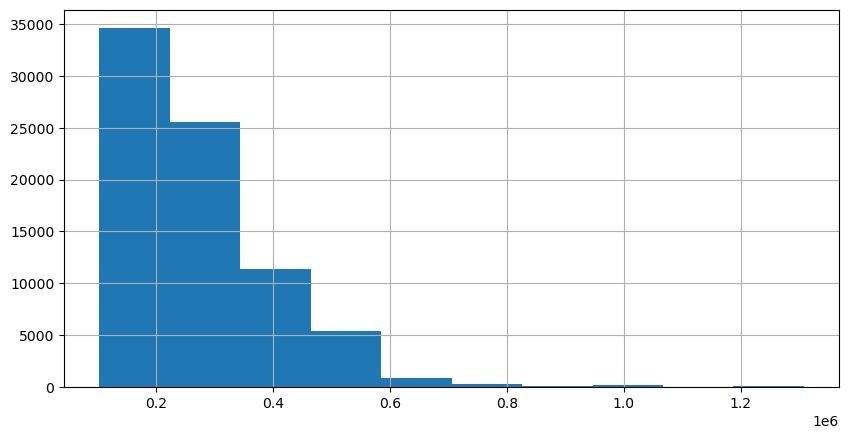

In [80]:
df_raw2['HPI_AveragePrice'].hist()

In [81]:
# # inspect numerical feats

# bsp.num_plotchart(df, float_cols)

### Item Age

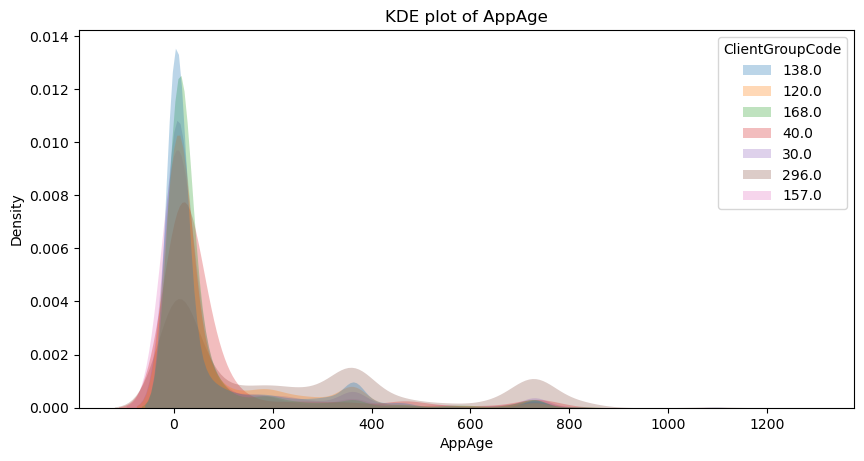

In [83]:
bsp.grouped_num_kde(df, 'AppAge', 'ClientGroupCode')

### Purchase Price

In [84]:
# cap price
df = df[df['PurchasePrice'] <= 1500]

#bin price

# bins = [0,200,250,300, 400, 500, 1500]

# df['item_price_bin'] = pd.cut(df['PurchasePrice'] , bins)

/tmp/ipykernel_21082/2035819757.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['item_price_bin'] = pd.cut(df['PurchasePrice'] , bins)


In [85]:
# df['purchaseprice_premium_ratio'] = df['PurchasePrice']/df['TotalPrice']
# df['purchaseprice_premium_ratio'].isna().any()

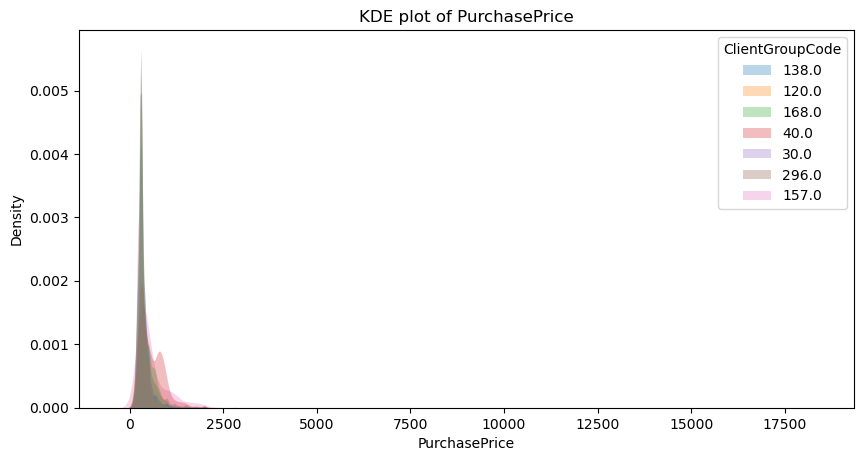

In [86]:
bsp.grouped_num_kde(df_raw2, 'PurchasePrice', 'ClientGroupCode')

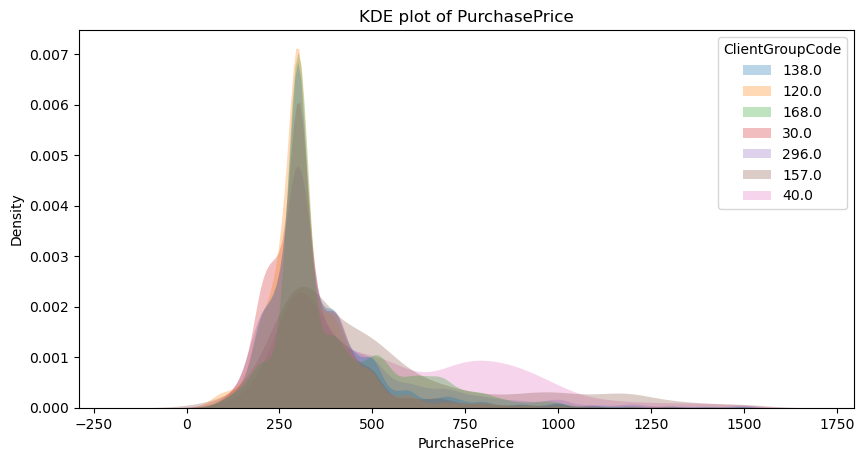

In [87]:
bsp.grouped_num_kde(df, 'PurchasePrice', 'ClientGroupCode')

<AxesSubplot:>

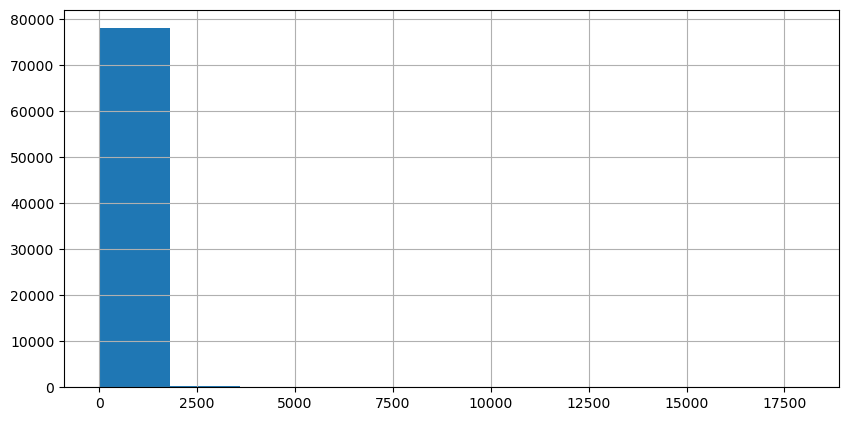

In [88]:
df_raw2['PurchasePrice'].hist()

<AxesSubplot:>

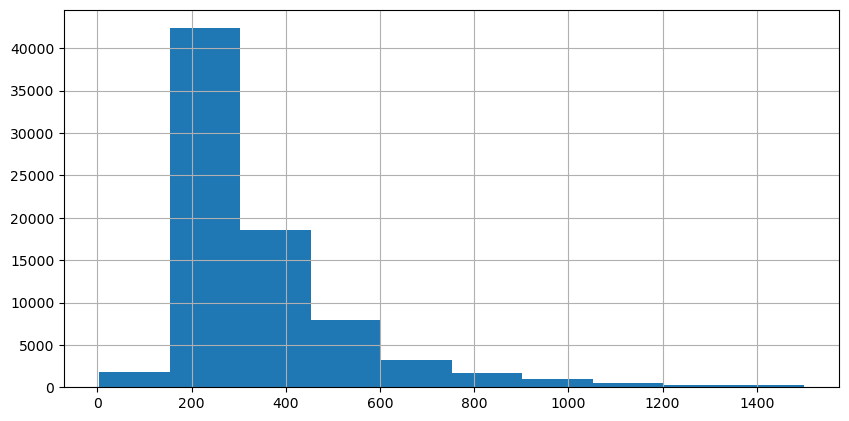

In [89]:
df['PurchasePrice'].hist()

In [90]:
df['item_price_bin'].isna().any()

False

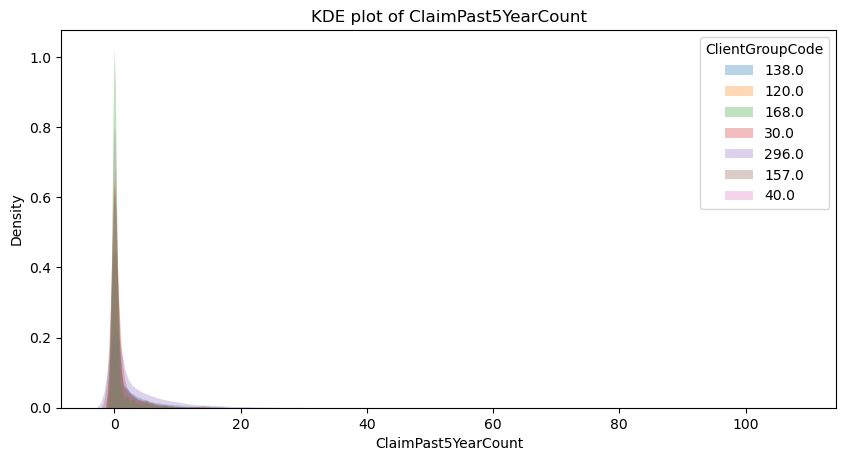

In [91]:
# ClaimPast5YearCount not capped
bsp.grouped_num_kde(df, 'ClaimPast5YearCount', 'ClientGroupCode')

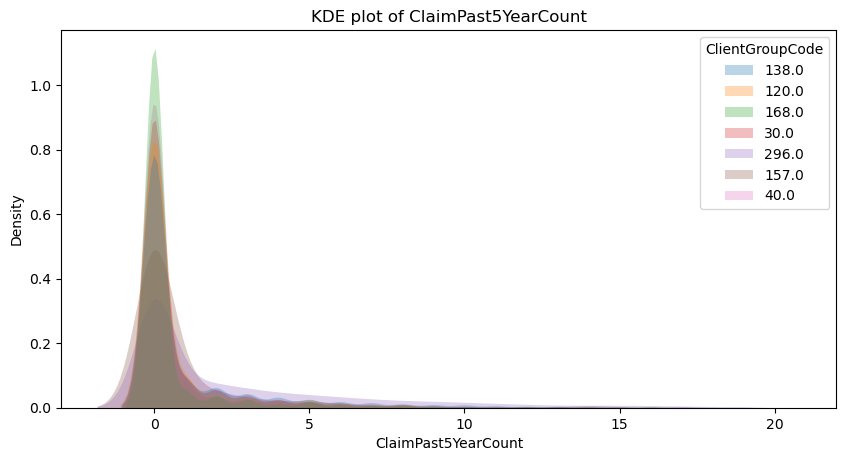

In [92]:
# ClaimPast5YearCount capped below 50
bsp.grouped_num_kde(df[df['ClaimPast5YearCount']<20], 'ClaimPast5YearCount', 'ClientGroupCode')

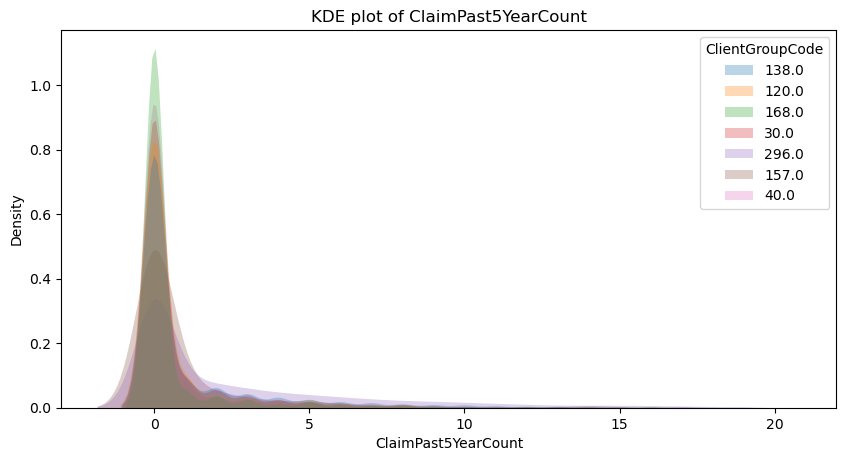

In [93]:
# ClaimPast5YearCount capped below 20
bsp.grouped_num_kde(df[df['ClaimPast5YearCount']<20], 'ClaimPast5YearCount', 'ClientGroupCode')

In [94]:
# cap claims

df = df[df['ClaimPast5YearCount']<=10]

In [95]:
#bin claim count

# bins = [-1, 0, 1, 3, 5, 7, 10, 20, 30, 50]
# bins = [-1, 0, 1, 3, 5, 7, 10]

# df['claimpastfiveyearcount_bin'] = pd.cut(df['ClaimPast5YearCount'] , bins)

## Redundant & Leaky Features
<a id='leak'></a>

In [96]:
df_raw3 = df.copy()

In [97]:
df_clean = hf.drop_columns(df_raw3, parameters.leaky_feats + parameters.redundant_feats + date_cols)

In [120]:
set1 = set(parameters.leaky_feats + parameters.redundant_feats)
set2 = set(drop_list)
# missing_columns = list(sorted(set1 - set2)) # missing values in set1
# check for common values in 2 lists
set1.intersection(set2)

{'PerhId',
 'PmhId',
 'contract_age',
 'contractcompanycode',
 'contractcreateddate',
 'contractdimensionid',
 'contractenddate',
 'contracteventdatetime',
 'contractmovementdate',
 'contractnumber',
 'contractoriginalstartdate',
 'contractschemecode',
 'contractstatusname',
 'gross',
 'itemcategoryname',
 'itemcategoryname_dup',
 'itemdiamondcopyid',
 'itemdiamondcopyid_imputed',
 'itemgoldencopyid',
 'itemlocationpostcode',
 'itemlocationpostcode_dup',
 'itemmodelnumber',
 'itemmodelnumber_dup',
 'itemmodelnumber_imputed',
 'itempurchasedatetime',
 'itemsupercategorycode',
 'manufacturerbrandname_dup',
 'offer_request_time',
 'offeracceptedindicator',
 'offersourcereceiveddatetime',
 'pcds',
 'persongoldencopyid',
 'persongoldencopyid_dup',
 'planno',
 'planstatus',
 'postcode_sector',
 'rec_status',
 'region',
 'year'}

## Outlier Treatment
<a id='out'></a>

In [98]:
# remove outliers 

# df_filt = df_clean[~df_clean['item_age'].isin(dif.findoutliers(df_clean.item_age))]
df_filt = df_clean[~df_clean['PurchasePrice'].isin(dif.findoutliers(df_clean.PurchasePrice))]
df_filt.shape

(66881, 56)

# Modelling
<a id='section5'></a>

In [99]:
# set predictors & response

categorical_cols, integer_cols, float_cols, date_cols, unidentified_cols = hf.cat_num_split(df_filt)

predictors = list(set(categorical_cols + float_cols + integer_cols) - set(['cancelflag']))
response = 'cancelflag'

In [100]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,6 hours 2 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.4
H2O_cluster_version_age:,4 months and 30 days !!!
H2O_cluster_name:,H2O_from_python_ubuntu_at1vqz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.39 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


## Feature Importance
<a id='featimp'></a>

In [101]:
df = df_filt.copy()

In [102]:
# further outlier treatment

for i in ['ClaimAmount5YearTotal', 'PlansCancelledPast5YearCount', 'PlansActivePast1yrCount', 'PlansAcceptedPast5YearCount', 'PlansAcceptedPast1YearCount', 'AppAge', 'PlanLiveCount'
]:    
    df = df[~df[i].isin(dif.findoutliers(df[i]))]

In [103]:
# convert columns to factors
for i in df_filt.columns:
    df[i] = df_filt[i].astype('category')
    
#train test split
x_train, x_test, y_train, y_test = train_test_split(df[predictors], df[response], test_size = 0.2, random_state = 1)
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)

# preserve training & test data's index to be used as a key to merge prediction probability with main dataset 
xtrain_index = x_train.index
xtest_index = x_test.index

# convert to h2o dataframe format
hf_train = h2o.H2OFrame(train)
hf_test = h2o.H2OFrame(test)

# format target to fit the model
hf_train['cancelflag']=hf_train['cancelflag'].asfactor()
hf_test['cancelflag']=hf_test['cancelflag'].asfactor()

# initialise the estimator 
df_gbm_imp = H2OGradientBoostingEstimator(keep_cross_validation_predictions=True, nfolds = 5, seed = 1)
start = time.time()

# train the model
df_gbm_imp.train(x = predictors, y = response, training_frame = hf_train)
end = time.time()
print(end - start)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/home/ubuntu/anaconda3/lib/python3.9/site-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [ClaimPast3YearCount, ClaimPast5YearCount, ClaimAmount5YearTotal, ClaimAmount1YearTotal, PlansCancelledPast1YearCount, PlansCancelledPast5YearCount, PlansActivePast1yrCount, ClaimAmount3YearTotal, ClaimPast1YearCount, PlansActivePast5yrCount, PlanLiveCount, PlansAcceptedPast1YearCount, PlansAcceptedPast5YearCount]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
11.147026300430298


In [104]:
# Retrieve the variable importance
varimp = df_gbm_imp.varimp(use_pandas=True).sort_values('scaled_importance', ascending=False)
feats_stored_gbm = list(varimp.head(20)['variable'])
varimp.head(20)

,variable,relative_importance,scaled_importance,percentage
0,AppAge,185.132690,1.000000,0.071094
1,ClientAccountDesc,167.386032,0.904141,0.064279
2,HPI_SalesVolume,133.449814,0.720833,0.051247
3,ONS_avg_dependent_children_per_family,132.034668,0.713189,0.050703
4,ManufacturerBrandCode,127.962822,0.691195,0.049140
5,ONS_bedrooms per rooms,111.092468,0.600069,0.042661
6,HPI_AveragePrice,101.761223,0.549666,0.039078
7,ApplianceCode,100.180550,0.541128,0.038471
8,ONS_%people_working_49+,98.140190,0.530107,0.037687
9,ONS_avg_age,92.101204,0.497488,0.035368


In [105]:
# df_gbm_imp.varimp_plot()

In [106]:
model_perf_stats(df_gbm_imp, hf_train, hf_test)

MCC: 0.37351 / 0.20558
F1: 0.52534 / 0.43356
AUC: 0.77150 / 0.64301
AUC PR: 0.58118 / 0.39100
Accuracy: 0.79538 / 0.75934
Logloss: 0.50574 / 0.53636
KS: 0.37272


In [107]:
y_true = y_test
y_pred = df_gbm_imp.predict(hf_test)
y_pred = y_pred.as_data_frame()

# classification report
print(classification_report(y_true, y_pred['predict'], labels=[0,1]))

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      4457
           1       0.37      0.48      0.42      1456

    accuracy                           0.67      5913
   macro avg       0.59      0.61      0.59      5913
weighted avg       0.70      0.67      0.68      5913



## Multicollinearity
<a id='multicol'></a>

In [108]:
predictors2 =  list(feats_stored_gbm)

df_ = df_filt.copy()

cat_predictors2 = df_[predictors2].select_dtypes(include=['object']).columns.tolist()
cat_predictors2

['ClientAccountDesc',
 'ManufacturerBrandCode',
 'ApplianceCode',
 'ClientGroupDesc']

In [109]:
# apply leave one out encoder to non-ordinal feats
for feature in ['ApplianceCode','ClientAccountDesc','ManufacturerBrandCode', 'ClientGroupDesc']:
    l1o_encoder, df_[feature] = get_leave_one_out(df_[feature], df_['cancelflag'])
    
# # apply get_ordinal to ordinal feats
# for feature in []:
#     ord_encoder, df_[feature] = get_ordinal(df_[feature])

In [110]:
# the independent variables set
X = df_[predictors2]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data.sort_values(by='VIF'))

                                   feature          VIF
0                                   AppAge     1.321451
2                          HPI_SalesVolume     3.266357
14                  ONS_population_density     3.608451
10                          ONS_n_families    10.187200
6                         HPI_AveragePrice    11.063410
19  ONS_avg_distance_travelled_to_work(km)    44.038650
8                  ONS_%people_working_49+    45.239713
3    ONS_avg_dependent_children_per_family    82.161968
7                            ApplianceCode   120.347748
18                     ONS_occupation_rate   130.283494
4                    ManufacturerBrandCode   242.141456
15           ONS_n_families_per_population   261.678441
17                        ONS_avg_bedrooms   339.638352
16                  ONS_%people_working_FT   514.860606
13                         ClientGroupDesc   530.364638
1                        ClientAccountDesc   596.612830
9                              ONS_avg_age   676

In [112]:
predictors3 = list(vif_data[vif_data['VIF']<100].feature.unique())
predictors3

['AppAge',
 'HPI_SalesVolume',
 'ONS_avg_dependent_children_per_family',
 'HPI_AveragePrice',
 'ONS_%people_working_49+',
 'ONS_n_families',
 'ONS_population_density',
 'ONS_avg_distance_travelled_to_work(km)']

In [113]:
# add/remove feats
predictors3.extend(['ManufacturerBrandCode', 'ONS_avg_bedrooms', 'ApplianceCode'])
# predictors3.remove('ONS_avg_household_size')     
# predictors3

# recalculate vif
# the independent variables set
X = df_[predictors3]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

                                   feature         VIF
0                                   AppAge    1.303387
1                          HPI_SalesVolume    3.163179
2    ONS_avg_dependent_children_per_family   32.057075
3                         HPI_AveragePrice   10.030324
4                  ONS_%people_working_49+   41.983045
5                           ONS_n_families    8.654966
6                   ONS_population_density    2.668842
7   ONS_avg_distance_travelled_to_work(km)   41.971957
8                    ManufacturerBrandCode   89.948048
9                         ONS_avg_bedrooms  110.630024
10                           ApplianceCode   97.338814


## Model 1 - GBM
<a id='gbm'></a>

In [114]:
# predictors3 = list(varimp.head(23)['variable'])

# convert columns to factors
for i in df_filt.columns[0:]:
    df[i] = df_filt[i].astype('category')

# re train test split
x_train, x_test, y_train, y_test = train_test_split(df[predictors3], df[response], test_size = 0.2, random_state = 1)
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)

# preserve training & test data's index to be used as a key to merge prediction probability with main dataset 
xtrain_index = x_train.index
xtest_index = x_test.index

# convert to h2o dataframe format
hf_train = h2o.H2OFrame(train)
hf_test = h2o.H2OFrame(test)

# format target to fit the model
hf_train['cancelflag']=hf_train['cancelflag'].asfactor()
hf_test['cancelflag']=hf_test['cancelflag'].asfactor()

df_gbm = H2OGradientBoostingEstimator(keep_cross_validation_predictions=True, nfolds = 5, seed = 1)

start = time.time()
# train the model
df_gbm.train(x = predictors3, y = response, training_frame = hf_train)
end = time.time()
print(end - start)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
9.169754028320312


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.82      0.63      0.71      4457
           1       0.34      0.57      0.42      1456

    accuracy                           0.62      5913
   macro avg       0.58      0.60      0.57      5913
weighted avg       0.70      0.62      0.64      5913

MCC: 0.33880 / 0.17488
F1: 0.50737 / 0.42962
AUC: 0.74631 / 0.63722
AUC PR: 0.54910 / 0.38452
Accuracy: 0.78972 / 0.76137
Logloss: 0.51176 / 0.53624
KS: 0.34886


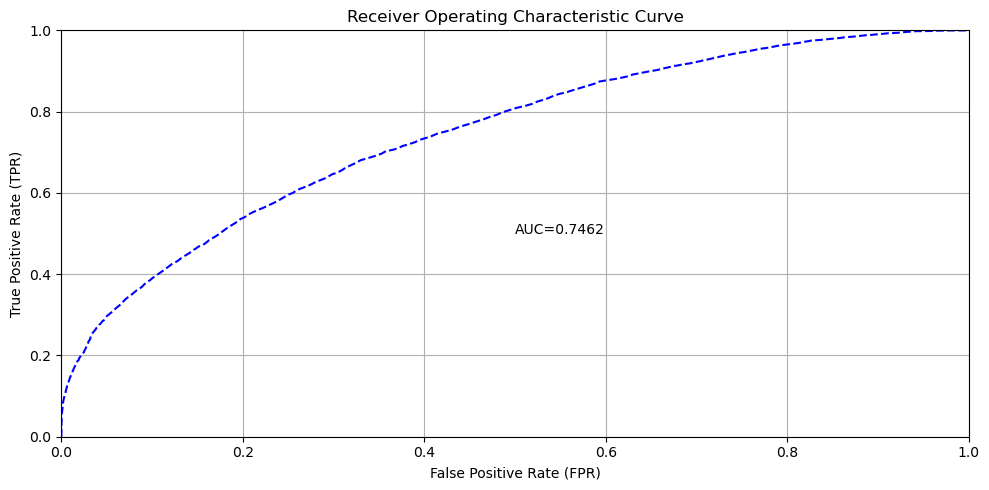

AUC of cross-validated holdout predictions: 0.6321549716683242


In [115]:
# classification report
y_true = y_test
y_pred = df_gbm.predict(hf_test)
y_pred = y_pred.as_data_frame()

print(classification_report(y_true, y_pred['predict'], labels=[0,1]))

# performance metrics
model_perf_stats(df_gbm, hf_train, hf_test)

# training auc plot
performance = df_gbm.model_performance(train=True)
performance.plot();# cross validation

# AUC of cross-validated holdout predictions
print(f'AUC of cross-validated holdout predictions: {df_gbm.auc(xval=True)}')

In [116]:
# Variable Importance

df_gbm.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,ManufacturerBrandCode,360.141083,1.000000,0.153930
1,AppAge,273.586609,0.759665,0.116935
2,ONS_%people_working_49+,268.478668,0.745482,0.114752
3,ONS_n_families,236.187546,0.655820,0.100951
4,ONS_avg_dependent_children_per_family,235.805557,0.654759,0.100787
5,HPI_SalesVolume,230.774902,0.640790,0.098637
6,ONS_avg_distance_travelled_to_work(km),175.597015,0.487578,0.075053
7,ONS_avg_bedrooms,161.635773,0.448812,0.069086
8,HPI_AveragePrice,151.955963,0.421935,0.064949
9,ApplianceCode,141.303436,0.392356,0.060395


## Model 2: GLM
<a id='glm'></a>

In [ ]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(df[predictors3], df[response], test_size = 0.2, random_state = 1)
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)

# preserve training & test data's index to be used as a key to merge prediction probability with main dataset 
xtrain_index = x_train.index
xtest_index = x_test.index

# convert to h2o dataframe format
hf_train = h2o.H2OFrame(train)
hf_test = h2o.H2OFrame(test)
# initialise the estimator 
df_glm = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True,
                                          remove_collinear_columns = True, 
                                          keep_cross_validation_predictions=True, 
                                          nfolds = 5, 
                                          seed = 1)
start = time.time()
# train the model
df_glm.train(x = predictors3, y = response, training_frame = hf_train)
end = time.time()
print(end - start)

In [ ]:
# classification report
y_true = y_test
y_pred = df_glm.predict(hf_test)
y_pred = y_pred.as_data_frame()

print(classification_report(y_true, y_pred['predict'], labels=[0,1]))

# performance metrics
model_perf_stats(df_glm, hf_train, hf_test)

# training auc plot
performance = df_glm.model_performance(train=True)
performance.plot();

# cross validation

# AUC of cross-validated holdout predictions
print(f'AUC of cross-validated holdout predictions: {df_glm.auc(xval=True)}')

In [ ]:
# Variable Importance

df_glm.varimp(use_pandas=True)

## Model 3: Random Forest
<a id='rf'></a>

In [ ]:
df_rf = H2ORandomForestEstimator(ntrees=50, max_depth=10, nfolds=5, keep_cross_validation_predictions=True, seed = 1)

start = time.time()
# train the model
df_rf.train(x = predictors3, y = response, training_frame = hf_train)
end = time.time()
print(end - start)

In [ ]:
# classification report
y_true = y_test
y_pred = df_rf.predict(hf_test)
y_pred = y_pred.as_data_frame()

print(classification_report(y_true, y_pred['predict'], labels=[0,1]))

# performance metrics
model_perf_stats(df_rf, hf_train, hf_test)

# training auc plot
performance = df_rf.model_performance(train=True)
performance.plot();

# cross validation

# AUC of cross-validated holdout predictions
df_rf.auc(xval=True)

In [ ]:
# Variable Importance

df_rf.varimp(use_pandas=True)